In [1]:
import torch
print(torch.version.cuda)  # Should display the CUDA version, not None
print(torch.cuda.is_available())  # Should return True if CUDA is correctly set up


11.7
True


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from joblib import dump
from tqdm import tqdm

# Definicja funkcji do tworzenia sekwencji
def create_sequences_with_max_target(X, y, time_steps=300, start_index=350):

    Xs, ys = [], []
    for i in range(start_index, len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(max(y[i:(i + time_steps)]))

    return np.array(Xs), np.array(ys)

# Definicja architektury modelu LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=3, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=dropout_rate, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

# Sprawdzenie dostępności GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Wczytywanie danych
directory = os.getcwd()
feature_columns = ['2x', '2y', '2z', '3x', '3y', '3z', '4x', '4y', '4z', 
                   'resultant_acceleration_1', 'resultant_acceleration_2', 
                   'resultant_acceleration_3', 'resultant_velocity1', 
                   'resultant_velocity2', 'resultant_velocity3', 
                   'velocity_2x', 'velocity_2y', 'velocity_2z', 
                   'velocity_3x', 'velocity_3y', 'velocity_3z', 
                   'velocity_4x', 'velocity_4y', 'velocity_4z']
df = pd.concat([pd.read_excel(os.path.join(directory, filename)) for filename in os.listdir(directory) if filename.endswith('.xlsx')], ignore_index=True)

# Oddzielenie cech od zmiennej docelowej przed skalowaniem
features = df[feature_columns]
target = df['Total_GRF']

# Skalowanie tylko cech
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Tworzenie sekwencji
# Creating sequences
 # Window size to look for the maximum value of Total_GRF, capturing 0.05 seconds

X_seq, y_seq = create_sequences_with_max_target(features_scaled, target.values, time_steps=350)


# Podział na zestawy treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Konwersja do tensorów PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Inicjalizacja modelu
model = LSTMModel(input_dim=X_train.shape[2], hidden_dim=50, num_layers=3, output_dim=1, dropout_rate=0.3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Trenowanie modelu
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as tepoch:
        for xb, yb in tepoch:
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

# Ocena modelu na zbiorze testowym
with torch.no_grad():
    model.eval()
    y_pred = []
    for xb, _ in test_loader:
        output = model(xb)
        y_pred.extend(output.cpu().numpy().flatten())  # Gather predictions



# Zapisanie modelu i parametrów skalowania
torch.save({
    'model_state_dict': model.state_dict(),
}, 'model.pth')

dump(scaler, 'scaler.joblib')


Epoch 20/20: 100%|██████████| 5536/5536 [00:32<00:00, 168.01batch/s, loss=5.26e+4]


['scaler.joblib']

In [3]:
from sklearn.metrics import r2_score  # Import r2_score from sklearn.metrics
# Ocena modelu na zbiorze testowym
with torch.no_grad():
  model.eval()
  y_pred = []
  for xb, _ in test_loader:
    output = model(xb)
    y_pred.extend(output.cpu().numpy().flatten()) # Gather predictions

r_squared = r2_score(y_test, y_pred)
print(f"R² score: {r_squared:.4f}")

# Zapisanie modelu i parametrów skalowania


R² score: 0.9615


In [4]:
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, y_pred)
print(f"R² score: {r_squared:.4f}")

R² score: 0.9615


In [5]:
import torch # Loading the checkpoint
checkpoint = torch.load('model.pth', map_location=device)

# Loading the model state
model.load_state_dict(checkpoint['model_state_dict'])

# Moving the model to the specified device (GPU or CPU)
model.to(device)

# Ensure the model is in evaluation mode if you're not continuing training
model.eval()


LSTMModel(
  (lstm): LSTM(24, 50, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [6]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
import pandas as pd
import torch
from joblib import load
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Zakładamy, że model jest już wczytany i gotowy do użycia
feature_columns = ['2x', '2y', '2z', '3x', '3y', '3z', '4x', '4y', '4z', 
                   'resultant_acceleration_1', 'resultant_acceleration_2', 
                   'resultant_acceleration_3', 'resultant_velocity1', 
                   'resultant_velocity2', 'resultant_velocity3', 
                   'velocity_2x', 'velocity_2y', 'velocity_2z', 
                   'velocity_3x', 'velocity_3y', 'velocity_3z', 
                   'velocity_4x', 'velocity_4y', 'velocity_4z']

# Odtworzenie skalera z zapisanego pliku
scaler = load('scaler.joblib')

# Użycie bieżącego katalogu
folder_path = '.'

# Pętla przechodząca przez wszystkie pliki w bieżącym folderze
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx'):  # Sprawdzanie, czy plik jest plikiem Excel
        new_data = pd.read_excel(file_name)

        # Usuwanie kolumn, które nie były używane podczas skalowania i dopasowywania modelu
        new_data_prepared = new_data.drop(['Time', 'Total_GRF'], axis=1)

        # Upewnienie się, że kolumny są w tej samej kolejności, co podczas dopasowania skalera
        new_data_prepared = new_data_prepared[feature_columns]

        # Przeskalowanie nowych danych przy użyciu wcześniej dopasowanego skalera
        new_data_scaled = scaler.transform(new_data_prepared)

        # Konwersja przeskalowanych danych do tensora PyTorch
        new_data_scaled_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device).unsqueeze(0)

        # Wykonanie predykcji
        model.eval()  # Przełączenie modelu w tryb ewaluacji
        with torch.no_grad():  # Wyłączenie obliczania gradientów
            predictions = model(new_data_scaled_tensor).cpu().numpy()

        # Wyświetlenie nazwy pliku i odpowiadających mu predykcji
        print(f"Predykcje dla {file_name}: {predictions}")


Predykcje dla agata_dollyo_lewa_event_1.xlsx: [[949.2391]]
Predykcje dla agata_dollyo_lewa_event_2.xlsx: [[1098.157]]
Predykcje dla agata_dollyo_lewa_event_3.xlsx: [[1049.899]]
Predykcje dla agata_dollyo_lewa_event_4.xlsx: [[1012.1932]]
Predykcje dla agata_dollyo_lewa_event_5.xlsx: [[886.86926]]
Predykcje dla agata_dollyo_prawe_event_1.xlsx: [[1408.4408]]
Predykcje dla agata_dollyo_prawe_event_2.xlsx: [[1460.4335]]
Predykcje dla agata_dollyo_prawe_event_3.xlsx: [[1404.7311]]
Predykcje dla agata_dollyo_prawe_event_4.xlsx: [[1259.511]]
Predykcje dla agata_dollyo_prawe_event_5.xlsx: [[1051.9299]]
Predykcje dla agata_dollyo_trad_l_event_1.xlsx: [[989.7106]]
Predykcje dla agata_dollyo_trad_l_event_2.xlsx: [[790.09076]]
Predykcje dla agata_dollyo_trad_l_event_3.xlsx: [[532.74146]]
Predykcje dla agata_dollyo_trad_l_event_4.xlsx: [[528.1494]]
Predykcje dla agata_dollyo_trad_l_event_5.xlsx: [[269.38934]]
Predykcje dla agata_dollyo_trad_p_event_1.xlsx: [[342.5467]]
Predykcje dla agata_dollyo_tra

'Predykcje dla Untitled.ipynb: [[2020.8848]]'

In [42]:
import pandas as pd
import torch
from joblib import load
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Zakładamy, że masz już wczytany model i jest on gotowy do użycia, a także że 'device' jest zdefiniowane
feature_columns = ['2x', '2y', '2z', '3x', '3y', '3z', '4x', '4y', '4z', 
                   'resultant_acceleration_1', 'resultant_acceleration_2', 
                   'resultant_acceleration_3', 'resultant_velocity1', 
                   'resultant_velocity2', 'resultant_velocity3', 
                   'velocity_2x', 'velocity_2y', 'velocity_2z', 
                   'velocity_3x', 'velocity_3y', 'velocity_3z', 
                   'velocity_4x', 'velocity_4y', 'velocity_4z']
# Odtworzenie skalera z zapisanego pliku
scaler = load('scaler.joblib')

# Wczytywanie nowego pliku danych
new_data = pd.read_excel(r'C:\Users\Lenovo\zrzut dyski hp\zeszyt siła tkd\NN\all_kicks_model\dane poza modelem\dollyo trad\eventy dt\marcin_d_t_p_event_5.xlsx')

# Usuwanie kolumn, które nie były używane podczas skalowania i dopasowywania modelu
new_data_prepared = new_data.drop(['Time', 'Total_GRF'], axis=1)

# Upewnienie się, że kolumny są w tej samej kolejności, co podczas dopasowania skalera
new_data_prepared = new_data_prepared[feature_columns]

# Przeskalowanie nowych danych przy użyciu wcześniej dopasowanego skalera
new_data_scaled = scaler.transform(new_data_prepared)

# Konwersja przeskalowanych danych do tensora PyTorch
# Dodajemy .unsqueeze(0) jeśli przetwarzamy pojedynczy przykład, aby dodać wymiar batchu
new_data_scaled_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device).unsqueeze(0)

# Wykonanie predykcji
model.eval()  # Przełączenie modelu w tryb ewaluacji
with torch.no_grad():  # Wyłączenie obliczania gradientów
    predictions = model(new_data_scaled_tensor).cpu().numpy()

# Wyświetlenie predykcji
print(predictions)

[[1688.5164]]


In [11]:
import copy
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

# Funkcja do przeprowadzania analizy permutacji dla wszystkich cech
def permutation_feature_importance_for_all_features(model, X_test, y_test, feature_columns, device):
    original_scores = {}
    permuted_scores = {}

    # Ocena modelu na oryginalnym zbiorze testowym
    model.eval()
    with torch.no_grad():
        y_pred = []
        for xb in DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device)), batch_size=8):
            output = model(xb[0])  # Poprawka tutaj
            y_pred.extend(output.cpu().numpy().flatten())
    original_r_squared = r2_score(y_test, y_pred)
    
    # Iteruj przez wszystkie cechy
    for i, feature in enumerate(feature_columns):
        X_test_permuted = copy.deepcopy(X_test)
        np.random.shuffle(X_test_permuted[:, :, i])  # Przemieszaj wartości dla i-tej cechy

        # Ocena modelu na zmodyfikowanym zbiorze testowym
        with torch.no_grad():
            y_pred_permuted = []
            for xb in DataLoader(TensorDataset(torch.tensor(X_test_permuted, dtype=torch.float32).to(device)), batch_size=8):
                output = model(xb[0])  # Poprawka tutaj
                y_pred_permuted.extend(output.cpu().numpy().flatten())
                
        # Oblicz wynik R^2 dla zmodyfikowanego zbioru
        permuted_r_squared = r2_score(y_test, y_pred_permuted)
        
        # Zapisz wyniki
        original_scores[feature] = original_r_squared
        permuted_scores[feature] = permuted_r_squared

    return original_scores, permuted_scores

# Przeprowadzenie analizy permutacji dla wszystkich cech
original_scores, permuted_scores = permutation_feature_importance_for_all_features(model, X_test, y_test, feature_columns, device)

# Wyświetlenie wyników
print("Oryginalny wynik R²:", original_scores[next(iter(original_scores))])
print("Wyniki R² po permutacji dla każdej cechy:")
for feature in feature_columns:
    print(f"{feature}: {permuted_scores[feature]:.4f}")


Oryginalny wynik R²: 0.9714723637788351
Wyniki R² po permutacji dla każdej cechy:
2x: 0.9272
2y: 0.9320
2z: 0.9185
3x: 0.9126
3y: 0.8999
3z: 0.8921
4x: 0.9274
4y: 0.9550
4z: 0.9460
resultant_acceleration_1: 0.6674
resultant_acceleration_2: 0.8818
resultant_acceleration_3: 0.8489
resultant_velocity1: 0.8325
resultant_velocity2: 0.9146
resultant_velocity3: 0.8888
velocity_2x: 0.9309
velocity_2y: 0.9231
velocity_2z: 0.9172
velocity_3x: 0.8979
velocity_3y: 0.9133
velocity_3z: 0.8656
velocity_4x: 0.9377
velocity_4y: 0.9166
velocity_4z: 0.9033


Analiza permutacji cech: 100%|██████████| 24/24 [00:41<00:00,  1.74s/it]


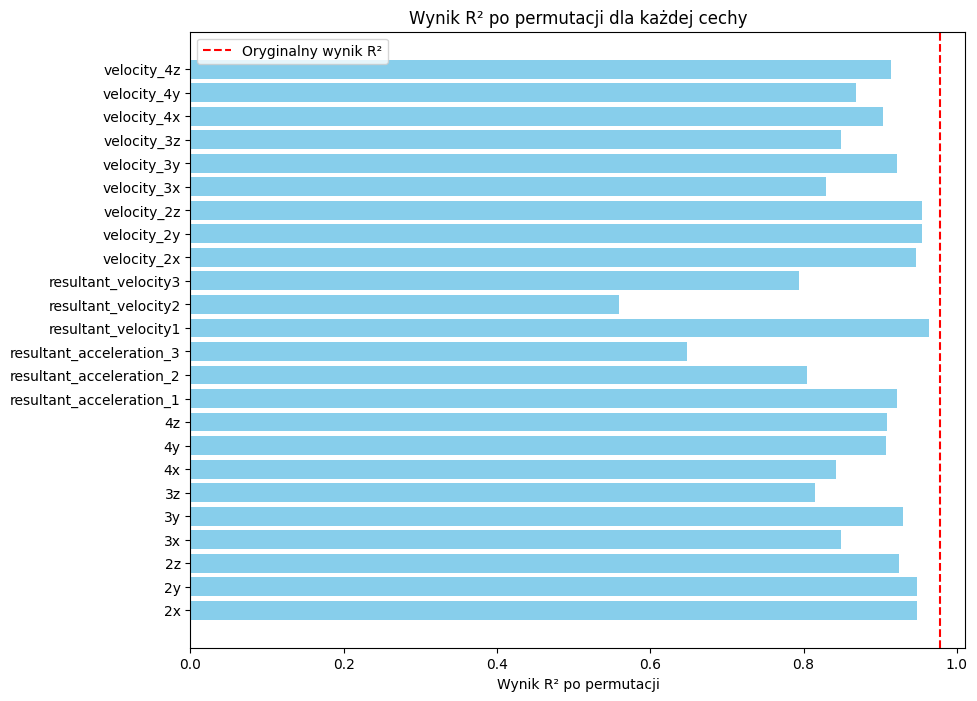

In [12]:
import copy
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Funkcja do przeprowadzania analizy permutacji dla wszystkich cech
def permutation_feature_importance_for_all_features(model, X_test, y_test, feature_columns, device):
    original_scores = {}
    permuted_scores = {}

    # Ocena modelu na oryginalnym zbiorze testowym
    model.eval()
    with torch.no_grad():
        y_pred = []
        for xb in DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device)), batch_size=32):
            output = model(xb[0])  # Poprawka tutaj
            y_pred.extend(output.cpu().numpy().flatten())
    original_r_squared = r2_score(y_test, y_pred)
    
    # Iteruj przez wszystkie cechy z paskiem postępu
    for i, feature in tqdm(enumerate(feature_columns), total=len(feature_columns), desc="Analiza permutacji cech"):
        X_test_permuted = copy.deepcopy(X_test)
        np.random.shuffle(X_test_permuted[:, :, i])  # Przemieszaj wartości dla i-tej cechy

        # Ocena modelu na zmodyfikowanym zbiorze testowym
        with torch.no_grad():
            y_pred_permuted = []
            for xb in DataLoader(TensorDataset(torch.tensor(X_test_permuted, dtype=torch.float32).to(device)), batch_size=32):
                output = model(xb[0])  # Poprawka tutaj
                y_pred_permuted.extend(output.cpu().numpy().flatten())
                
        # Oblicz wynik R^2 dla zmodyfikowanego zbioru
        permuted_r_squared = r2_score(y_test, y_pred_permuted)
        
        # Zapisz wyniki
        original_scores[feature] = original_r_squared
        permuted_scores[feature] = permuted_r_squared

    return original_scores, permuted_scores

# Przeprowadzenie analizy permutacji dla wszystkich cech
original_scores, permuted_scores = permutation_feature_importance_for_all_features(model, X_test, y_test, feature_columns, device)

# Wykresy
features = list(permuted_scores.keys())
permuted_scores_list = [permuted_scores[feature] for feature in features]

plt.figure(figsize=(10, 8))
plt.barh(features, permuted_scores_list, color='skyblue')
plt.xlabel('Wynik R² po permutacji')
plt.title('Wynik R² po permutacji dla każdej cechy')
plt.axvline(x=original_scores[next(iter(original_scores))], color='r', linestyle='--', label='Oryginalny wynik R²')
plt.legend()
plt.show()


Analiza permutacji cech: 100%|██████████| 24/24 [1:09:35<00:00, 174.00s/it]


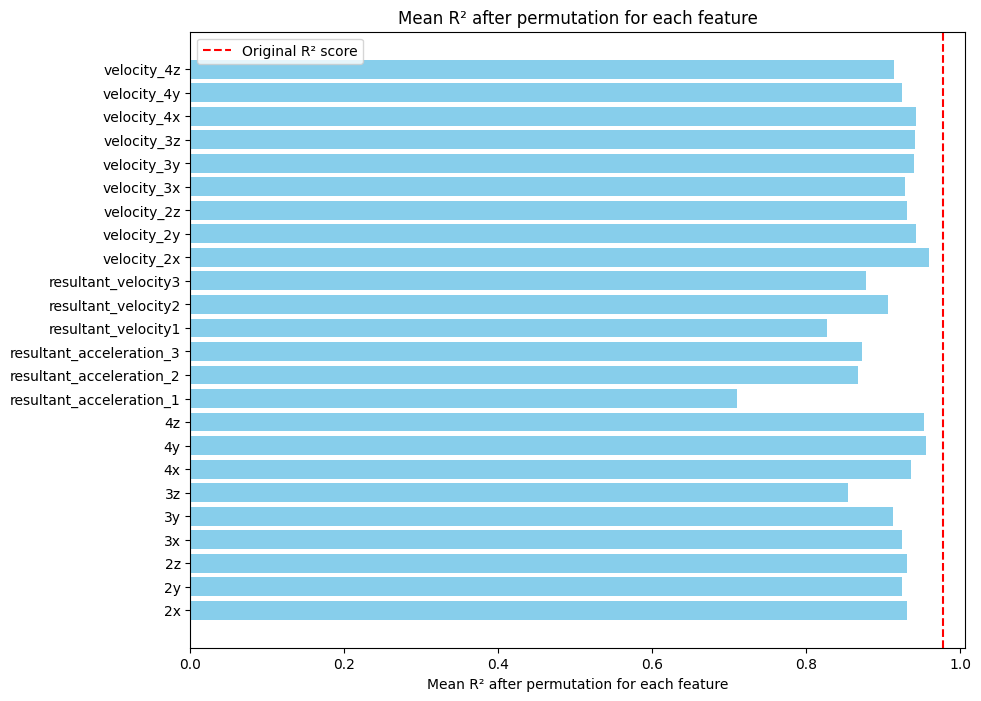

Oryginalny wynik R²: 0.9775152621578627
Wyniki R² po permutacji dla każdej cechy:
2x: 0.9306
2y: 0.9245
2z: 0.9312
3x: 0.9244
3y: 0.9126
3z: 0.8543
4x: 0.9357
4y: 0.9557
4z: 0.9525
resultant_acceleration_1: 0.7106
resultant_acceleration_2: 0.8679
resultant_acceleration_3: 0.8725
resultant_velocity1: 0.8266
resultant_velocity2: 0.9059
resultant_velocity3: 0.8779
velocity_2x: 0.9589
velocity_2y: 0.9429
velocity_2z: 0.9308
velocity_3x: 0.9279
velocity_3y: 0.9405
velocity_3z: 0.9408
velocity_4x: 0.9428
velocity_4y: 0.9241
velocity_4z: 0.9139


In [5]:
import copy
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Funkcja do przeprowadzania analizy permutacji dla wszystkich cech z wielokrotnymi przebiegami
def permutation_feature_importance_for_all_features(model, X_test, y_test, feature_columns, device, num_runs=30):
    original_scores = {}
    permuted_scores_mean = {}

    # Ocena modelu na oryginalnym zbiorze testowym
    model.eval()
    with torch.no_grad():
        y_pred = []
        for xb in DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device)), batch_size=16):
            output = model(xb[0])
            y_pred.extend(output.cpu().numpy().flatten())
    original_r_squared = r2_score(y_test, y_pred)
    
    # Iteruj przez wszystkie cechy z paskiem postępu
    for feature in tqdm(feature_columns, desc="Analiza permutacji cech"):
        permuted_scores = []
        for _ in range(num_runs):  # Przeprowadź num_runs permutacji dla każdej cechy
            X_test_permuted = copy.deepcopy(X_test)
            np.random.shuffle(X_test_permuted[:, :, feature_columns.index(feature)])  # Przemieszaj wartości dla cechy

            # Ocena modelu na zmodyfikowanym zbiorze testowym
            with torch.no_grad():
                y_pred_permuted = []
                for xb in DataLoader(TensorDataset(torch.tensor(X_test_permuted, dtype=torch.float32).to(device)), batch_size=16):
                    output = model(xb[0])
                    y_pred_permuted.extend(output.cpu().numpy().flatten())
                    
            # Oblicz wynik R^2 dla zmodyfikowanego zbioru
            permuted_r_squared = r2_score(y_test, y_pred_permuted)
            permuted_scores.append(permuted_r_squared)
        
        # Oblicz średni wynik R^2 z permutacji dla cechy
        permuted_scores_mean[feature] = np.mean(permuted_scores)
        
        # Zapisz wyniki
        original_scores[feature] = original_r_squared

    return original_scores, permuted_scores_mean

# Przeprowadzenie analizy permutacji dla wszystkich cech
original_scores, permuted_scores_mean = permutation_feature_importance_for_all_features(model, X_test, y_test, feature_columns, device, num_runs=100)

# Wykresy
features = list(permuted_scores_mean.keys())
permuted_scores_list = [permuted_scores_mean[feature] for feature in features]

plt.figure(figsize=(10, 8))
plt.barh(features, permuted_scores_list, color='skyblue')
plt.xlabel('Mean R² after permutation for each feature')
plt.title('Mean R² after permutation for each feature')
plt.axvline(x=original_scores[next(iter(original_scores))], color='r', linestyle='--', label='Original R² score')
plt.legend()
plt.show()

# Wyświetlenie wyników
print("Oryginalny wynik R²:", original_scores[next(iter(original_scores))])
print("Wyniki R² po permutacji dla każdej cechy:")
for feature in feature_columns:
    print(f"{feature}: {permuted_scores_mean[feature]:.4f}")
